In [27]:
import numpy as np
import create_distribution as cr
import hamiltonian_2 as hm
import one_matrix_model as om
import importlib
importlib.reload(cr)
from qiskit.quantum_info import Statevector, DensityMatrix
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.algorithms import TimeEvolutionProblem
import Ansatz as an
importlib.reload(an)
from qiskit.algorithms import VarQITE
from qiskit.primitives import Estimator
from qiskit.quantum_info.states.measures import state_fidelity
from time import process_time
import one_matrix_model as om
from qiskit.quantum_info import SparsePauliOp
from utility import generate_combinations




### D=1, N=5

For N=5 , I also have some values, but the evaluation plot shows me that the results were not thath sensible. You can see it in the following plot:



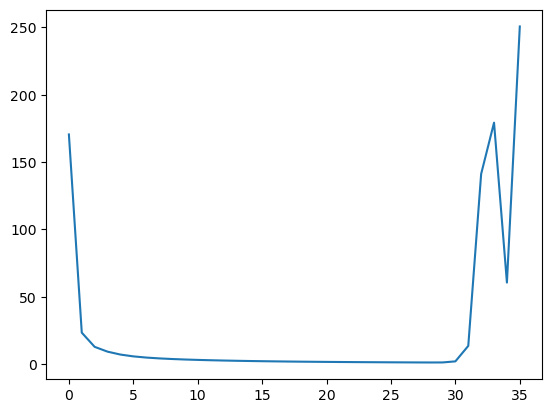

In [14]:
h_exp_val_4=[170.5,         23.37262847,  12.83911432,   9.2723476,    7.11411099,
   5.77182845,   4.89077474,   4.27333618,   3.81220756,   3.44899843,
   3.15125627,   2.90026801,   2.68468261,   2.49718012,   2.3327196
,   2.1876059 ,   2.05898326,   1.94455367,   1.84241458,   1.75096089,
   1.66882242,   1.59482111,   1.52793993,   1.46729884,   1.41213553,
   1.36179043,   1.31570939,   1.27365965,   1.23889821,   1.26258938,
   2.06477763,  13.55169196, 141.1725104 , 179.22575793,  60.54429435,
 250.63519809]
plt.plot(range(len(h_exp_val_4)), h_exp_val_4)

Because of this behaviour, I decided to go to my other dataset:

### Results for N=4, D=1 (2*2 Matrices, 2^4 discretization points for every eigenvalue)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35]


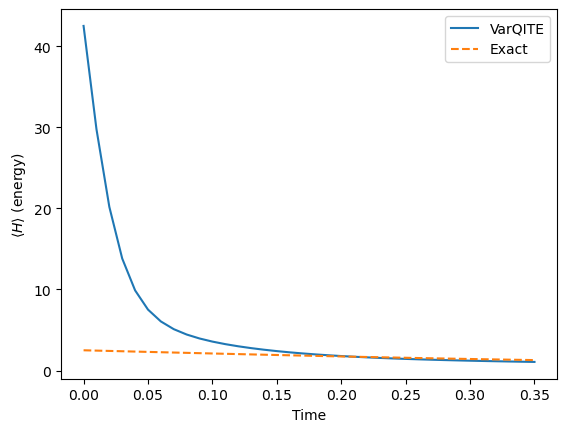

In [15]:
evolution_n_4 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/run_MORE_4.dipf_evolution.npy", allow_pickle=True).item()
scipy_n_4 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/scipyresult.npy",allow_pickle =True)

exact_exp_val = scipy_n_4[0]
print(evolution_n_4.times)
cr.compare_results_exp(evolution_n_4,exact_exp_val)


Varqite seems to run normal(I did not plot it with scipy generated evolution like we did in d=0 case, because it was taking too long, I will do it on the clusters in the future), so I continue:

In [16]:
#Hamiltonian a**( - lamda_1^2 - lambda_2 ^2)
power =2
qubits_per_dim = 4
D= 1
a =1
lambdas = []
for i in range(D+1):
    lambdas.append(om.create_lambda_2(i, D, qubits_per_dim))
hamiltonian = 0
for i in range(D+1):
    hamiltonian += (a ** 2) * lambdas[i].power(power)

In [17]:
#data
evolution_n_4 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/run_MORE_4.dipf_evolution.npy", allow_pickle=True).item()

In [18]:
state = Statevector(evolution_n_4.evolved_state) #builds the current state fir quantum circuit
value =state.expectation_value(om.vandermonde_2(1,4).power(2), list(range(0,8))) #this builds pho=|psi><psi, traces out the qubits 8..15, then calculates tr(operator * rho_traced), so what we want( I tried it also by numpy step by step)
print(value)

(1.0644712071703077+0j)


In [19]:
#the "result" in the function calculates the data without varqite. Function gives us how far we are. Pow is the power of vandermonde
def difference(value_, beta_, hamiltonian_, observable):
    result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
    return np.abs(value_-result)

In [20]:
beta=0.7
vandermonde = om.vandermonde_2(1,4).power(2)
print(difference(value,beta, hamiltonian,vandermonde))

0.3641608751366825


But if we decide pow =1 , we find 0. So the integral $(\int (x-y)e^{(-x^2-y^2) * \beta})$ is correctly evaluated.  This give me the impression that the evolved state has the wrong $\beta$ 

In [21]:
#for pow 1, exp value
state.expectation_value(om.vandermonde_2(1,4).power(1), list(range(0,8)))

(6.554068745854206e-16+0j)

So I plotted the behaiour of differences with varying beta

In [22]:
beta_values = np.linspace(0.35, 1.4, 100)
results = []
for beta in beta_values:
    result = difference(value, beta, hamiltonian, vandermonde)
    results.append(result)
plt.plot(beta_values, results)
plt.xlabel('Beta')
plt.ylabel('Result')
plt.title('Plot of Difference Function for Different Beta Values')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [ ]:
# find best beta
def objective_function(beta):
    return difference(value,beta, hamiltonian,vandermonde)

initial_guess = 0.9
result = minimize(objective_function, initial_guess)
min_beta = result.x[0]
print("Minimum value of beta:", min_beta)
min_value = result.fun
print("Minimum value of the function:", min_value)

Minimum value of beta: 0.9405263311272964
Minimum value of the function: 3.702871786970263e-09


If I also evaluate the discretized Integral with the minimal beta found in mathematica, I find the value: 1.06447. 

compare it with varqite result: 1.0644712071703077. To verify this, I also try the found $\beta$ with other powers of vandermonde:

In [ ]:
value_2  =state.expectation_value(om.vandermonde_2(1,4).power(4), list(range(0,8))) 

print(value_2)

(3.531221832169532+0j)


In [ ]:
vandermonde_4 = om.vandermonde_2(1,4).power(4)
difference(value_2,0.9405263311272964, hamiltonian,vandermonde_4)

0.14572607866407283

calculated vander
loop: 0.8
loop: 0.8210526315789474
loop: 0.8421052631578948
loop: 0.8631578947368421
loop: 0.8842105263157896
loop: 0.9052631578947369
loop: 0.9263157894736842
loop: 0.9473684210526316
loop: 0.968421052631579
loop: 0.9894736842105263
loop: 1.0105263157894737
loop: 1.0315789473684212
loop: 1.0526315789473684
loop: 1.0736842105263158
loop: 1.094736842105263
loop: 1.1157894736842104
loop: 1.1368421052631579
loop: 1.1578947368421053
loop: 1.1789473684210527
loop: 1.2


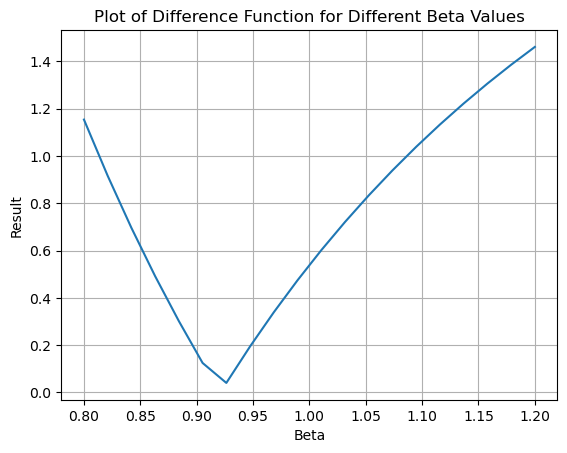

In [ ]:
beta_values = np.linspace(0.8, 1.2, 20)
print("calculated vander")
results = []
for beta in beta_values:
    result = difference(value_2, beta, hamiltonian, vandermonde_4)
    results.append(result)
    print("loop:", beta)
plt.plot(beta_values, results)
plt.xlabel('Beta')
plt.ylabel('Result')
plt.title('Plot of Difference Function for Different Beta Values')
plt.grid(True)
plt.show()

So $\beta=$ 0.94 seems like again the evolved value since it is the least difference!

## Depth=2, N=3, D=1


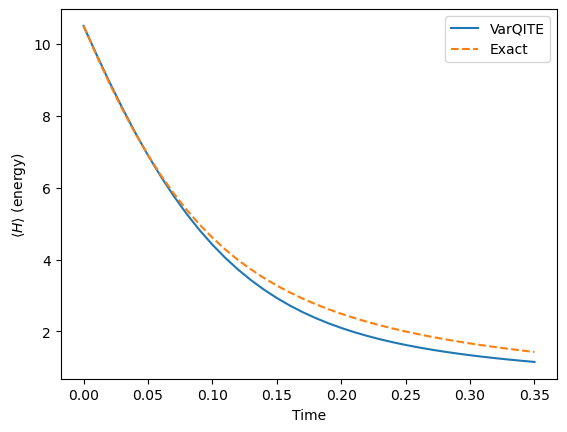

In [ ]:
evolution_n_3 = np.load("//Users/salsa/MatrixModels/matrixmodels/remote/results/run_D_1_N_3_depth_2_evolution.npy",allow_pickle= True).item()
scipy_n_3 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/scipy_D_1_N_3_depth_2_evolution .npy",allow_pickle =True)

exact_exp_val_3 = scipy_n_3[0]
cr.compare_results_exp(evolution_n_3,exact_exp_val_3)

In [ ]:
state_3= Statevector(evolution_n_3.evolved_state) #builds the current state fir quantum circuit
value_3 =state_3.expectation_value(om.vandermonde_2(1,3).power(2), list(range(0,6))) #this builds pho=|psi><psi, traces out the qubits 8..15, then calculates tr(operator * rho_traced), so what we want( I tried it also by numpy step by step)
print(value_3)

(1.1516466252609938+0j)


In [ ]:
power =2
qubits_per_dim = 3
D= 1
a =1
lambdas = []
for i in range(D+1):
    lambdas.append(om.create_lambda_2(i, D, qubits_per_dim))
hamiltonian_3 = 0
for i in range(D+1):
    hamiltonian_3 += (a ** 2) * lambdas[i].power(power)

In [ ]:
vandermonde_3 =om.vandermonde_2(1,3).power(2)
difference(value_3,0.7,hamiltonian_3,vandermonde_3)

0.2769596737831437

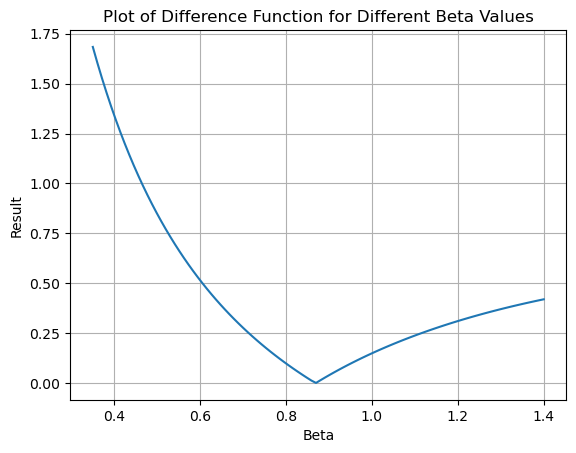

In [ ]:
beta_values = np.linspace(0.35, 1.4, 100)
results = []
for beta in beta_values:
    result = difference(value_3,beta,hamiltonian_3,vandermonde_3)
    results.append(result)
plt.plot(beta_values, results)
plt.xlabel('Beta')
plt.ylabel('Result')
plt.title('Plot of Difference Function for Different Beta Values')
plt.grid(True)
plt.show()

In [ ]:
def objective_function_2(beta):
    return difference(value_3,beta,hamiltonian_3,vandermonde_3)

initial_guess = 0.85
result = minimize(objective_function_2, initial_guess)
min_beta = result.x[0]
print("Minimum value of beta:", min_beta)
min_value = result.fun
print("Minimum value of the function:", min_value)

Minimum value of beta: 0.8687808481606651
Minimum value of the function: 5.88619597508e-10


## Depth =3, N=3, D=1

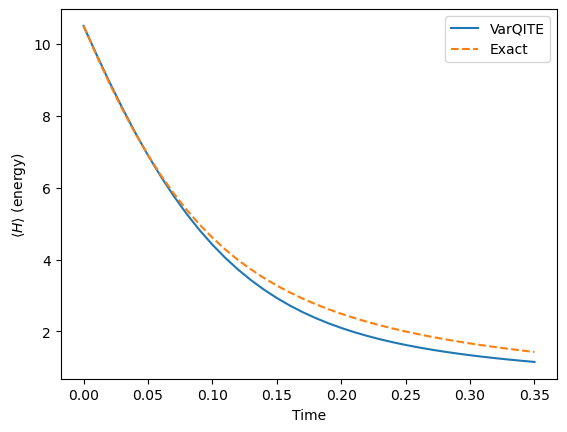

In [ ]:
evolution_n_3_3 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/run_D_1_N_3_depth_3_evolution.npy",allow_pickle= True).item()
scipy_n_3_3 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/scipy_D_1_N_3_depth_3_evolution.npy .npy",allow_pickle =True)

exact_exp_val_3_3 = scipy_n_3_3[0]
cr.compare_results_exp(evolution_n_3_3,exact_exp_val_3_3)

(1.1516466252609945+0j)


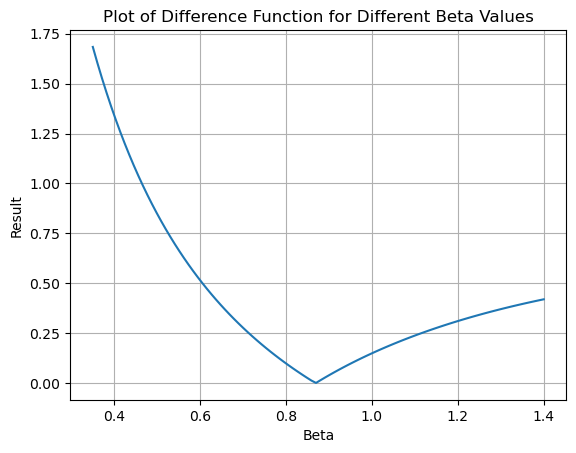

Minimum value of beta: 0.8687808481448003
Minimum value of the function: 6.095339788458887e-10


In [ ]:
state_3_3= Statevector(evolution_n_3_3.evolved_state) #builds the current state fir quantum circuit
value_3_3 =state_3_3.expectation_value(om.vandermonde_2(1,3).power(2), list(range(0,6))) #this builds pho=|psi><psi, traces out the qubits 8..15, then calculates tr(operator * rho_traced), so what we want( I tried it also by numpy step by step)
print(value_3_3)


beta_values = np.linspace(0.35, 1.4, 100)
results = []
for beta in beta_values:
    result = difference(value_3,beta,hamiltonian_3,vandermonde_3)
    results.append(result)
plt.plot(beta_values, results)
plt.xlabel('Beta')
plt.ylabel('Result')
plt.title('Plot of Difference Function for Different Beta Values')
plt.grid(True)
plt.show()

def objective_function_3(beta):
    return difference(value_3_3,beta,hamiltonian_3,vandermonde_3)

initial_guess = 0.85
result = minimize(objective_function_3, initial_guess)
min_beta = result.x[0]
print("Minimum value of beta:", min_beta)
min_value = result.fun
print("Minimum value of the function:",min_value)


## Timestep comparisons 

Maybe timesteps are the problem for varqite? Lets test, expectation values are evaluated for different timesteps

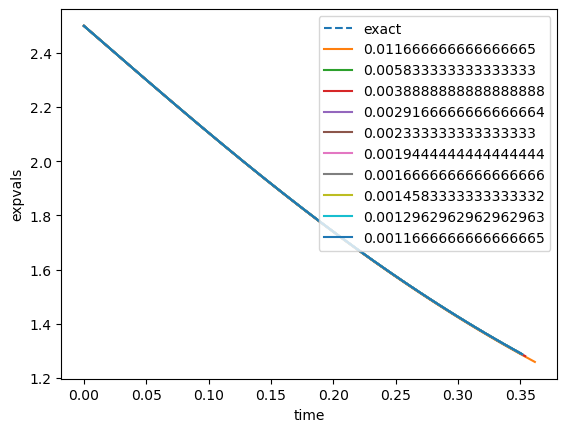

In [ ]:
evolutions = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/run_D_1_N_2_depth_1_timeseteps_evolution.npy", allow_pickle = True)
scipy_2 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/scipy_D_1_N_2_depth_1_evolution .npy", allow_pickle = True)

plt.plot(np.linspace(0,0.35,len(scipy_2[0])),scipy_2[0], label = "exact", linestyle='--' )
counter = 0
for evolution in evolutions:
    scipyexp = scipy_2[0]
    times = evolution.times
    expval = np.array([ele[0][0] for ele in evolution.observables])
    plt.plot(times,expval,  label = times[1]-times[0] )

plt.xlabel("time")
plt.ylabel("expvals")
plt.legend()
plt.show()

differences


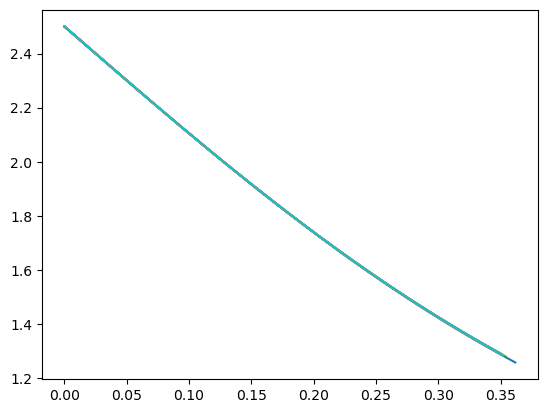

In [ ]:
for evolution in evolutions:
    scipyexp = scipy_2[0]
    scipy_time = scipy_2[1].times
    common_time = np.linspace(min(min(d['time'].min() for d in datasets), key=lambda x: x.min()),
                          max(max(d['time'].max() for d in datasets), key=lambda x: x.max()), 1000)

    interpolated_data1 = np.interp(common_time, time1, data1)
    interpolated_data2 = np.interp(common_time, time2, data2)

    difference = interpolated_data1 - interpolated_data2

    times = evolution.times
    expval = np.array([ele[0][0] for ele in evolution.observables])
    plt.plot(times,expval,  label = times[1]-times[0] )

In [ ]:
scipy_2[1].times

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35])

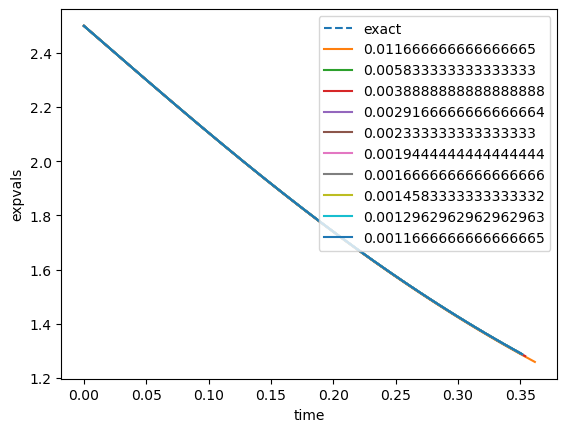

In [ ]:
evolutions = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/run_D_1_N_2_depth_1_timeseteps_evolution.npy", allow_pickle = True)
scipy_2 = np.load("/Users/salsa/MatrixModels/matrixmodels/remote/results/scipy_D_1_N_2_depth_1_evolution .npy", allow_pickle = True)

plt.plot(np.linspace(0,0.35,len(scipy_2[0])),scipy_2[0], label = "exact", linestyle='--' )
counter = 0
for evolution in evolutions:
    scipyexp = scipy_2[0]
    times = evolution.times
    expval = np.array([ele[0][0] for ele in evolution.observables])
    plt.plot(times,expval,  label = times[1]-times[0] )

plt.xlabel("time")
plt.ylabel("expvals")
plt.legend()
plt.show()

I will try for D = 0 

## D =0 N =4

In [ ]:
depth = 1
qubits = 4
hamiltonian = hm.hamiltonian(4,1,2)^hm.insert_i(4)
var_principle = ImaginaryMcLachlanPrinciple()
time = 0.35
aux_ops = [hamiltonian]
init_param_values =  [np.pi/2]*qubits + [0]*(depth*qubits*2+qubits)
ansatz = an.ansatz_review_exact(qubits*2,depth)
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
evolution_result = var_qite.evolve(evolution_problem)

(0.5322356035851565+0j)


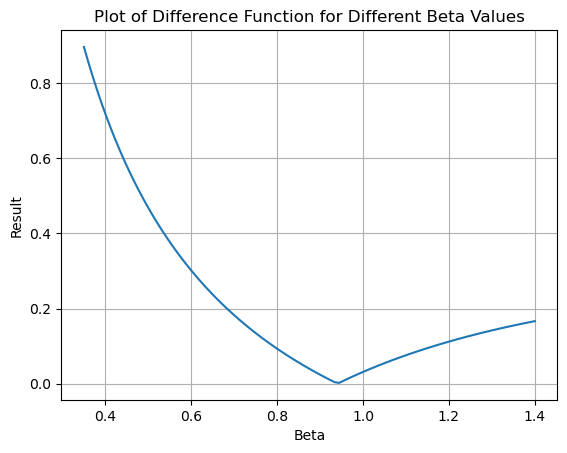

Minimum value of beta: 0.9405263288265541
Minimum value of the function: 3.139041360178396e-09


In [ ]:
real_ham = hm.hamiltonian(4,1,2)
def difference(value_, beta_, hamiltonian_, observable):
    result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
    return np.abs(value_-result)

state_3_3= Statevector(evolution_result.evolved_state) #builds the current state fir quantum circuit
value_3_3 =state_3_3.expectation_value(real_ham, list(range(0,4))) #this builds pho=|psi><psi, traces out the qubits 8..15, then calculates tr(operator * rho_traced), so what we want( I tried it also by numpy step by step)
print(value_3_3)


beta_values = np.linspace(0.35, 1.4, 100)
results = []
for beta in beta_values:
    result = difference(value_3_3,beta,real_ham,real_ham)
    results.append(result)
plt.plot(beta_values, results)
plt.xlabel('Beta')
plt.ylabel('Result')
plt.title('Plot of Difference Function for Different Beta Values')
plt.grid(True)
plt.show()

def objective_function_3(beta):
    return difference(value_3_3,beta,real_ham,real_ham)

initial_guess = 0.85
result = minimize(objective_function_3, initial_guess)
min_beta = result.x[0]
print("Minimum value of beta:", min_beta)
min_value = result.fun
print("Minimum value of the function:",min_value)

In [ ]:
dir(evolution_result)
parameters = evolution_result.parameter_values
states= []

for parameter in parameters:
    binded = an.ansatz_review_exact(qubits*2,depth).bind_parameters(parameter)
    state =Statevector(binded)
    states.append(state)
    

In [ ]:
times =np.linspace(0.01,0.35,35, endpoint=True)
print(times)
sols = []
for time in times:
    sol = cr.create_distribution_scipy(4,1,real_ham,time*2)[1].evolved_state
    sols.append(sol)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35]


In [ ]:
sols[0]

Statevector([ 2.98501884e-01+0.j, -4.36257799e-19+0.j,  8.77429730e-19+0.j,
             -2.19213773e-35+0.j, -3.80544531e-18+0.j, -5.76651468e-35+0.j,
              1.08224828e-34+0.j, -1.65072488e-51+0.j, -8.71474818e-18+0.j,
              8.88260501e-35+0.j, -3.02624891e-34+0.j, -3.66003609e-51+0.j,
              2.18127957e-34+0.j,  1.11789512e-51+0.j, -1.95766280e-51+0.j,
              1.61099600e-69+0.j, -1.08078416e-17+0.j,  2.44392672e-01+0.j,
              4.57701853e-19+0.j, -1.42636335e-35+0.j, -4.14832484e-18+0.j,
             -4.32686882e-35+0.j,  9.40448414e-35+0.j,  1.49101911e-51+0.j,
              8.12050258e-19+0.j, -3.00234584e-35+0.j,  1.99449303e-35+0.j,
             -5.07791709e-54+0.j,  1.58275999e-35+0.j, -2.50575739e-52+0.j,
             -4.61262227e-52+0.j, -1.79008870e-68+0.j,  5.03198489e-17+0.j,
             -1.75715691e-34+0.j,  2.81118488e-01+0.j, -4.67209639e-19+0.j,
             -4.77170937e-18+0.j,  5.67414240e-36+0.j,  1.97503999e-36+0.j,
            

In [ ]:
density_exact = (1/np.trace(np.exp(-beta* hamiltonian.to_matrix())) )* np.exp(-beta * hamiltonian.to_matrix()) * hamiltonian.to_matrix()
density_exact_ = DensityMatrix(density_exact)



In [ ]:
fidelities = []
counter_1=1


for state in states:
    counter_2= 1
    for exact in sols:
        if counter_1 == counter_2:
            print("I am in", counter_1, counter_2)
            fidelity = state_fidelity(state, exact, validate=False)
            fidelities.append(fidelity)
        counter_2 = counter_2 + 1
    counter_1 = counter_1 +1
    

I am in 1 1
I am in 2 2
I am in 3 3
I am in 4 4
I am in 5 5
I am in 6 6
I am in 7 7
I am in 8 8
I am in 9 9
I am in 10 10
I am in 11 11
I am in 12 12
I am in 13 13
I am in 14 14
I am in 15 15
I am in 16 16
I am in 17 17
I am in 18 18
I am in 19 19
I am in 20 20
I am in 21 21
I am in 22 22
I am in 23 23
I am in 24 24
I am in 25 25
I am in 26 26
I am in 27 27
I am in 28 28
I am in 29 29
I am in 30 30
I am in 31 31
I am in 32 32
I am in 33 33
I am in 34 34
I am in 35 35


Text(0.5, 1.0, 'comparison varqite vs scipy, D=0 N=4')

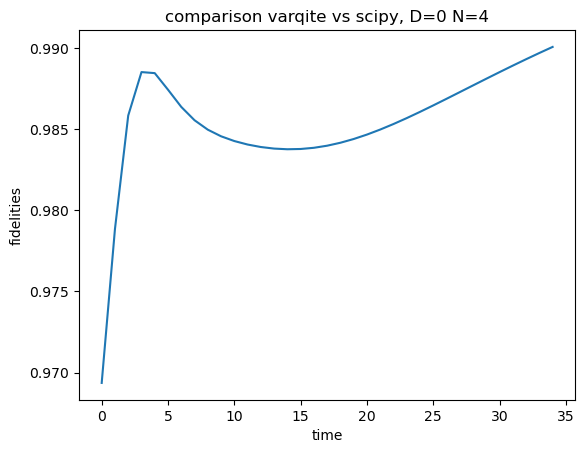

In [ ]:
plt.plot(range(len(fidelities)), fidelities)
plt.xlabel("time")
plt.ylabel("fidelities")
plt.title("comparison varqite vs scipy, D=0 N=4")

## Beta Comparisons for N=2,3,4,5,6,7,8, D=0

In [ ]:
depth = 1 
qubits_per_dim = [2,3,4,5,6,7]
dimension = 0
qubits = qubits_per_dim *(dimension+1)

In [ ]:

evolutions = []
min_betas = []
times = []
def difference(value_, beta_, hamiltonian_, observable):
    result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
    return np.abs(value_-result)


for N in qubits_per_dim :
    
    hamilton = hm.hamiltonian(N,1,2)
    time0= process_time()
    evolution = cr.create_distribution_2_varqite(N,1,hamilton , 0.7 )
    time1= process_time()
    time = time1-time0
    evolutions.append(evolution)
    state= Statevector(evolution.evolved_state) #builds the current state fir quantum circuit
    value =state.expectation_value(hamilton, list(range(0,N)))
    diff = difference(value, 0.7, hamilton, hamilton)
    def objective_function_3(beta):
        return difference(value,beta,hamilton,hamilton)
    initial_guess = 0.85
    result = minimize(objective_function_3, initial_guess)
    min_beta = result.x[0]
    min_betas.append(min_beta)
    times.append(time)

    print("completed loop:", N-1)
    
    
    


     

completed loop: 1
completed loop: 2
completed loop: 3
completed loop: 4


/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: overflow encountered in exp
  result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: overflow encountered in multiply
  result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: invalid value encountered in multiply
  result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  result =(1/np.trace(np.exp(-beta_*

completed loop: 5


/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: overflow encountered in exp
  result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: overflow encountered in multiply
  result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: invalid value encountered in multiply
  result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  result =(1/np.trace(np.exp(-beta_*

completed loop: 6


/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: overflow encountered in exp
  result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: invalid value encountered in multiply
  result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())
/var/folders/dk/2y17dwn916n0849gyw2c2q3c0000gn/T/ipykernel_7858/3049729146.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  result =(1/np.trace(np.exp(-beta_* hamiltonian_.to_matrix())) )* np.trace(np.exp(-beta_ * hamiltonian_.to_matrix()) * observable.to_matrix())


In [ ]:
min_betas

[0.7022693448871065,
 0.8687808444360978,
 0.9405263288265541,
 0.974508789009474,
 0.85,
 -704.93125]

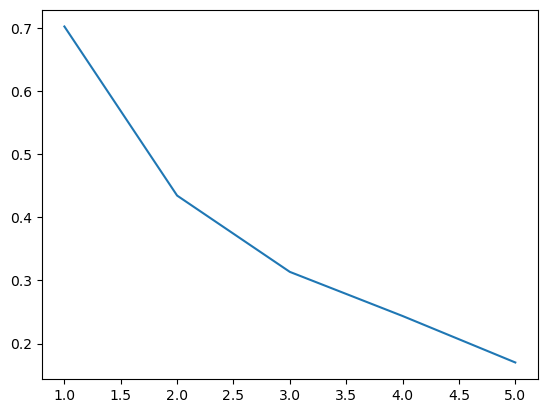

In [ ]:
plt.plot(np.arange(1,6), min_betas[:5]/np.arange(1,6))

In [ ]:
result_1 = 1/np.trace(np.exp(-0.7* hm.hamiltonian(3,1,2).to_matrix())) * np.trace(np.exp(-0.7 * hm.hamiltonian(3,1,2).to_matrix()) * hm.hamiltonian(3,1,2).to_matrix())
result_2 = 1/np.trace(np.exp(-0.87* hm.hamiltonian(3,1,2).to_matrix())) * np.trace(np.exp(-0.94 * hm.hamiltonian(3,1,2).to_matrix()) * hm.hamiltonian(3,1,2).to_matrix())

In [ ]:
compare_1= result_1/result_2

In [ ]:
compare_1

(1.3413621543080698+0j)

In [ ]:
copmpare_2 = result_1/result_2

In [ ]:
copmpare_2

(1.3943000623628374+0j)

# With the trick

it wooooorks

In [19]:

qubits_per_dim = 3
D= 1
a =1
factor = 1
lambdas = []
for i in range(D+1):
    lambdas.append(om.create_lambda_2(i, D, qubits_per_dim))
hamiltonian_3 = 0
for i in range(D+1):
    hamiltonian_3 += ((a ** 2) * lambdas[i].power(2) ) 

random_hamilton = SparsePauliOp(['ZZ', 'ZI',"IZ", "XI", "IX"],
      coeffs=[1.0,-0.2,-0.2,+0.3,+0.3])

In [28]:
param = 0#np.random.randint(-100,100)*0.00001
varqite_res = cr.create_distribution_2_varqite(qubits_per_dim* (D+1), 2, hamiltonian_3, 1, param)


54


In [22]:
scipy_result = cr.create_distribution_scipy(qubits_per_dim* (D+1), 1, hamiltonian_3, 1,param)

-0.009375892052047363


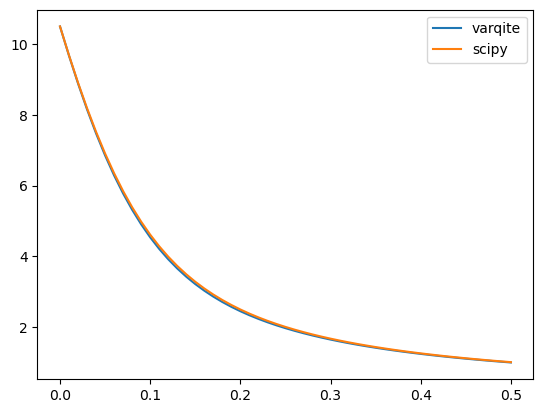

In [29]:
times = varqite_res.times
h_exp_val = np.array([ele[0][0] for ele in varqite_res.observables])
plt.plot(times, h_exp_val, label = "varqite")
plt.plot(0.01*np.arange(len(scipy_result[0])),scipy_result[0],label = "scipy")

plt.legend()
difference = h_exp_val[-1]-scipy_result[0][-1]
print(difference)

In [38]:
state_3= Statevector(varqite_res.evolved_state) #builds the current state fir quantum circuit
value_3 =state_3.expectation_value(om.vandermonde_2(1,3).power(2), list(range(0,6))) #this builds pho=|psi><psi, traces out the qubits 8..15, then calculates tr(operator * rho_traced), so what we want( I tried it also by numpy step by step)
print(value_3)

#value_4 = state_3.expectation_value(partial_trace(om.vandermonde_2(1,3).power(2),[0,1,2]), list(range(0,3))) *  state_3.expectation_value(partial_trace(om.vandermonde_2(1,3).power(2),[3,4,5]), list(range(3,6)))

#print(scipy_result[0][-1])


(0.9926661971916828+0j)


In [43]:
result_1 =   np.trace(np.exp(-hamiltonian_3.to_matrix()) * om.vandermonde_2(1,3).power(2).to_matrix())
print(result_1)
print(result_1/value_3)

0j


In [43]:
np.real(om.vandermonde_2(1,2).power(2).to_matrix().diagonal())

array([0., 1., 1., 4., 1., 0., 4., 9., 1., 4., 0., 1., 4., 9., 1., 0.])

In [36]:
matrix = om.create_lambda_2(0,1,3).power(2)+om.create_lambda_2(1,1,3).power(2)

In [39]:
np.trace(np.exp(-np.real(matrix.to_matrix()))* om.vandermonde_2(1,3).power(2).to_matrix()) / np.trace(np.exp(-np.real(matrix.to_matrix())))

(1.0020420892437285+0j)

In [155]:
 np.trace(np.exp(-np.real(matrix.to_matrix())))

3.1409427031011514

In [15]:
om.vandermonde_2(0,3)

SparsePauliOp(['III'],
              coeffs=[1.+0.j])

In [75]:
om.create_lambda_2(0,0,3)

SparsePauliOp(['ZII', 'ZII', 'ZZI', 'ZII', 'ZIZ'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0.5+0.j,  1. +0.j, -1. +0.j])

/Users/salsa/anaconda3/envs/MatrixModels/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 4 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salsa/anaconda3/envs/MatrixModels/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 5 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salsa/anaconda3/envs/MatrixModels/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 6 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salsa/anaconda3/envs/MatrixModels/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 7 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salsa/anaconda3/envs/MatrixModels/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salsa/anacond

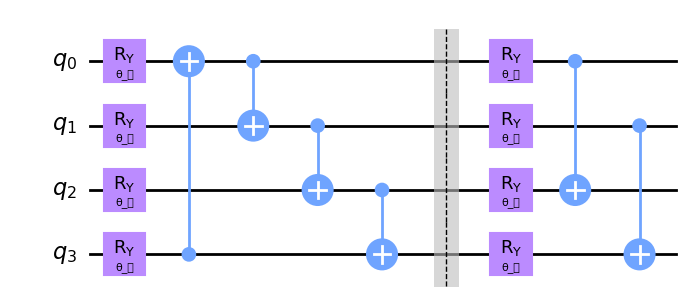

In [168]:
an.ansatz_review_exact(4,1).draw("mpl")

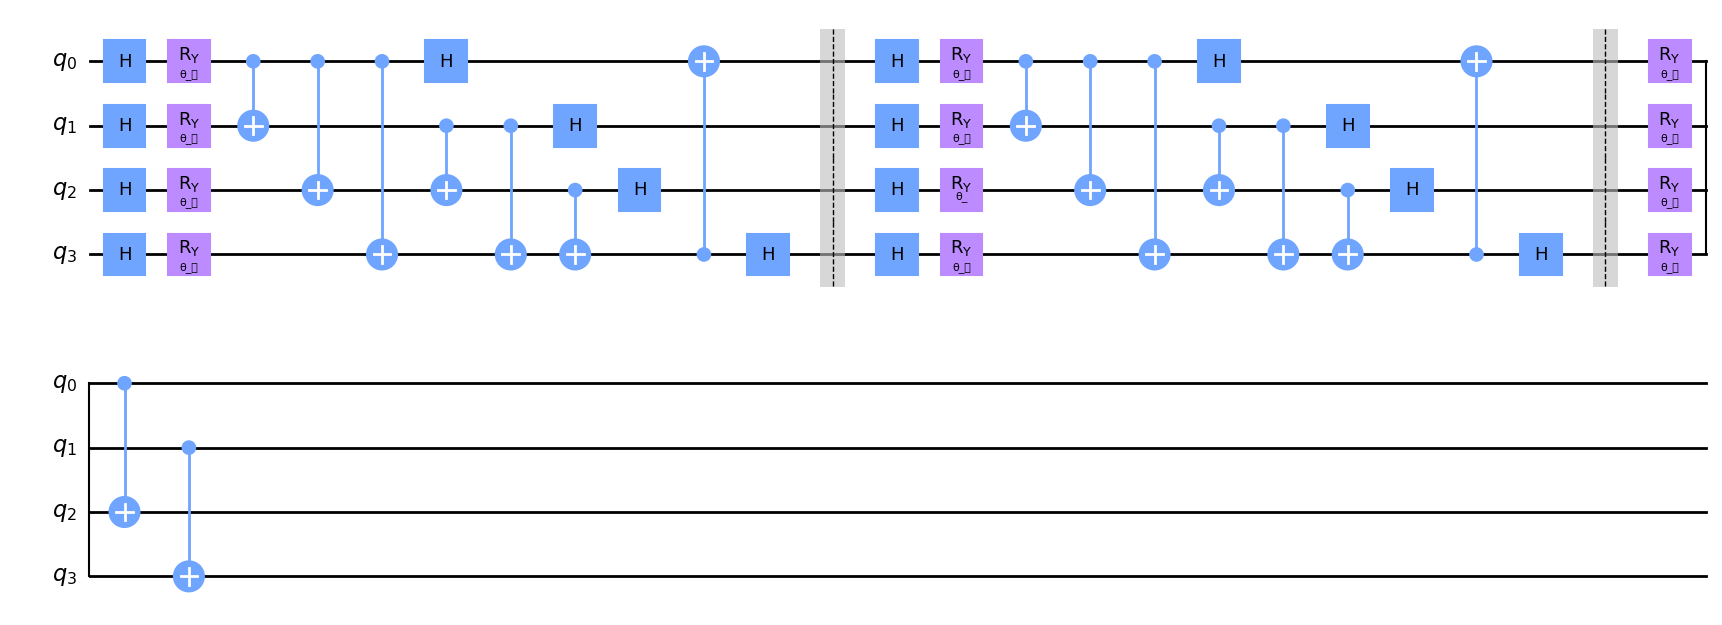

In [44]:
an.ansatz_review_exact_full(4,2).draw("mpl")

/Users/salsa/anaconda3/envs/MatrixModels/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 5 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salsa/anaconda3/envs/MatrixModels/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 6 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salsa/anaconda3/envs/MatrixModels/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 7 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salsa/anaconda3/envs/MatrixModels/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salsa/anaconda3/envs/MatrixModels/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salsa/anaconda3

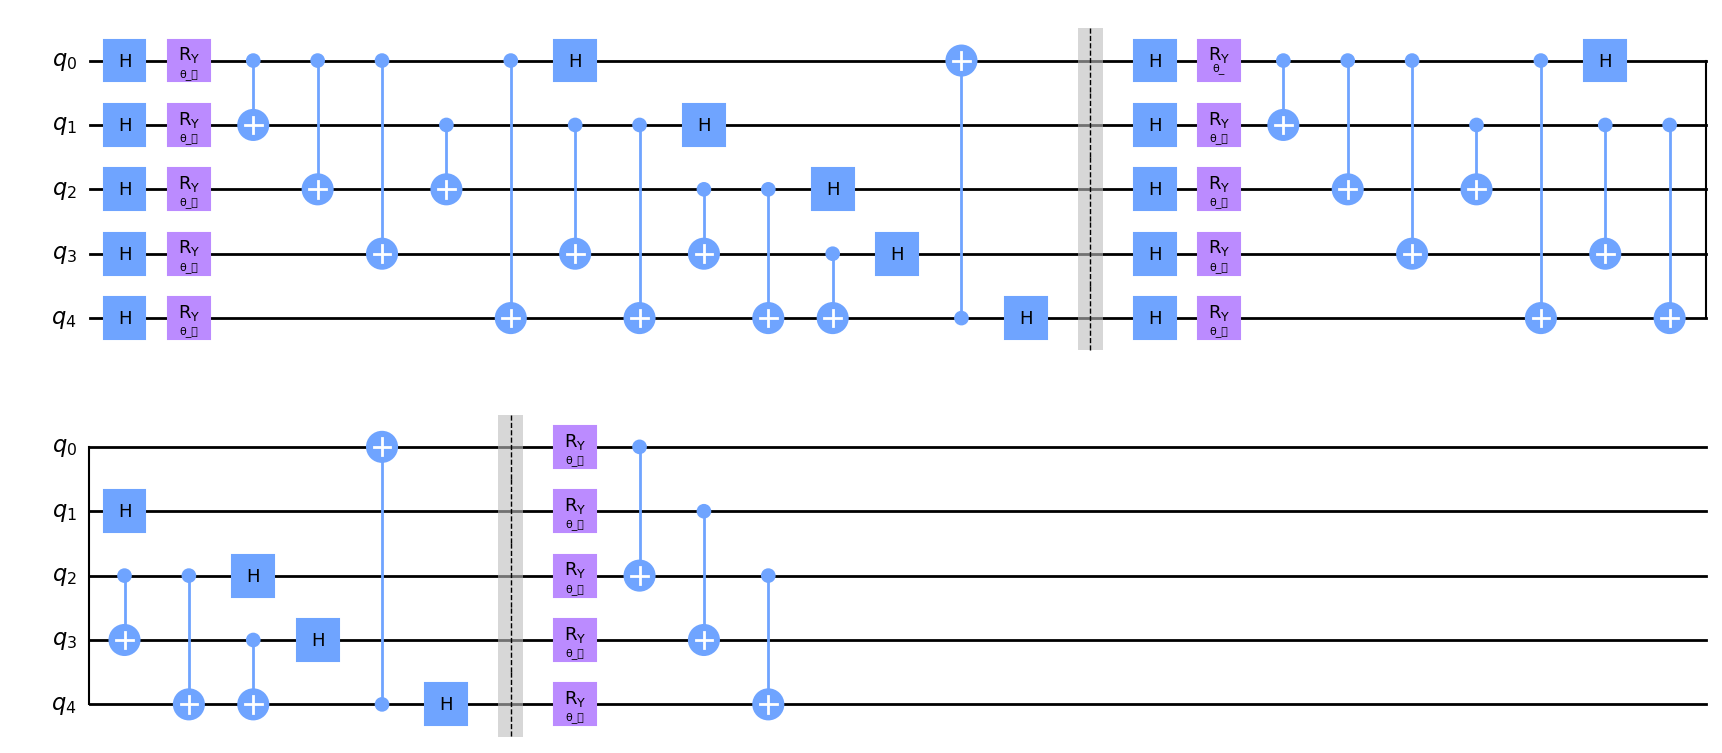

In [45]:
an.ansatz_review_exact_full(5,2).draw("mpl")

<BarContainer object of 8 artists>

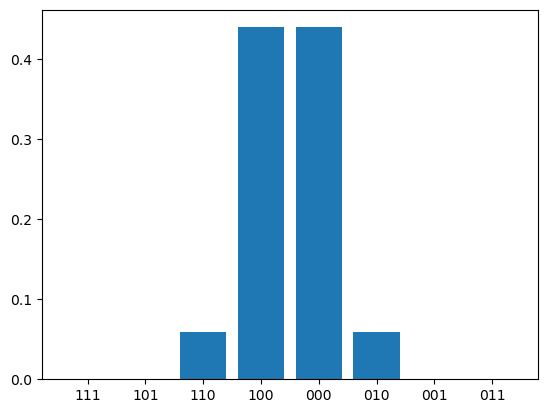

In [21]:
varqite_result = Statevector(varqite_res.evolved_state).probabilities_dict(np.arange(3))
x = generate_combinations(3- 1)
y = []
for i in range(len(x)):
    y.append(varqite_result[x[i]])
plt.bar(x,y)

2


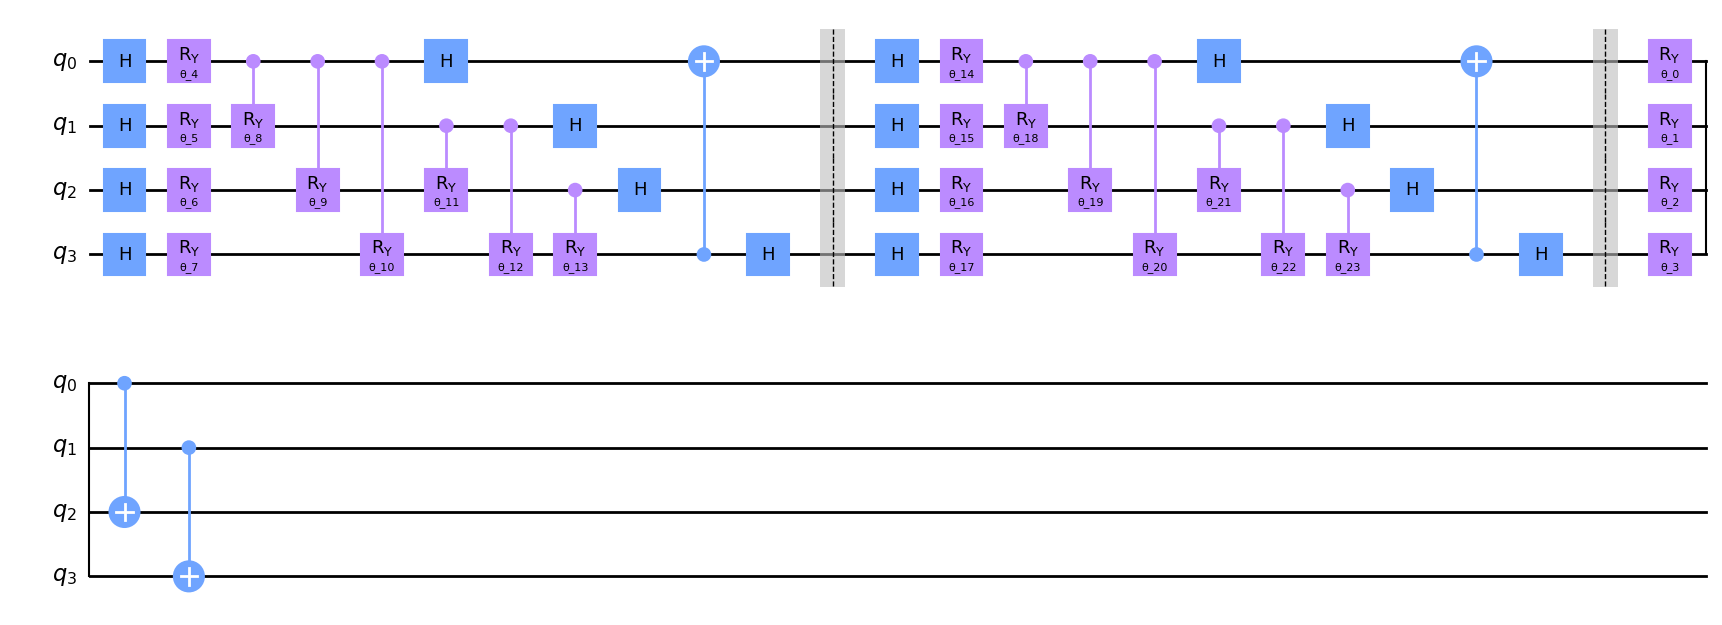

In [3]:
an.ansatz_review_exact_full_cry(4,2).draw("mpl")

In [11]:
depth =2
qubits=2

In [16]:
len([np.pi / 2 +param] * qubits + [0] * (depth * 2 * qubits  + qubits + int(depth*2*qubits*(2*qubits-1)/2)))

24